In [68]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, KBinsDiscretizer, PolynomialFeatures, OneHotEncoder
from category_encoders import target_encoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression, SGDRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn import  pipeline, compose, dummy, ensemble, kernel_ridge, neighbors, svm, isotonic
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion

In [67]:
from warnings import simplefilter
simplefilter("ignore", category=FutureWarning)

In [93]:
train = pd.read_csv("E:/Kaggle/Abalone Dataset/train.csv")
test = pd.read_csv("E:/Kaggle/Abalone Dataset/test.csv")
sample_submission = pd.read_csv("E:/Kaggle/Abalone Dataset/sample_submission.csv")

In [70]:
og = pd.read_csv("E:/Kaggle/Abalone Dataset/Original/abalone.data", header=None)
og.columns = train.drop('id', axis=1).columns

### Experimentation

In [100]:
_df_merged = pd.concat([
    train.drop(['id'], axis=1),
    og
]).reset_index(drop=True)
df_features = _df_merged.drop(['Rings'], axis=1)
ser_targets = _df_merged['Rings']
print(f'{df_features.shape=}\n{ser_targets.shape=}')

df_features.shape=(94792, 8)
ser_targets.shape=(94792,)


In [6]:
metric_cols = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
categorical_cols = ['Sex']
assert set(df_features.columns) == set(metric_cols+categorical_cols)

In [20]:
class RatioFeaturesGenerator(TransformerMixin):
    """Create features as simple proportion of feature A (numerator) to feature B (denominator). Columns must be numerical."""

    def __init__(self, log=False): #cols: list[str], l):
#         self.cols = cols
        self.log = log

    def fit(self, X: pd.DataFrame, y=None):
        self.columns_ = [f'log_{col}' for col in X.columns]
        return self
    
    def fit(self, X: np.ndarray | pd.DataFrame, y=None):
#         self.minimum_value  # 0 will be overwritten with this to avoid infinities
        return self    

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if isinstance(X, pd.DataFrame):
            columns = list(X.columns)
            X = X.copy()
        elif isinstance(X, np.ndarray):
            columns = [f'feature_{i}' for i in range(X.shape[1])]
            X = pd.DataFrame(X, columns=columns)
        else:
            raise ValueError
        
        X_generated = pd.DataFrame()
        for i_numerator in range(len(columns)):
            col_numerator = columns[i_numerator]
            for col_denominator in columns[i_numerator+1:]:
                if self.log:
                    ratio_feature_name = f'log_ratio_{col_numerator}_to_{col_denominator}'
                    X_generated[ratio_feature_name] = np.log(X[col_numerator].values.clip(min=0.0001) / X[col_denominator].values.clip(min=0.0001))
                else:
                    ratio_feature_name = f'ratio_{col_numerator}_to_{col_denominator}'
                    X_generated[ratio_feature_name] = X[col_numerator] / X[col_denominator].values.clip(min=0.0001)
        
        self.columns_ = list(X_generated.columns)
        return X_generated
    
    def get_feature_names_out(self, *args, **params):
        """
        enable native DataFrame output after...
            sklearn.set_config(transform_output = 'pandas')
        """
        return self.columns_
df_ratios = RatioFeaturesGenerator().fit_transform(df_features[metric_cols])
assert np.isinf(df_ratios).values.sum()  == 0
assert np.isnan(df_ratios).values.sum()  == 0
df_ratios.head()

,ratio_Length_to_Diameter,ratio_Length_to_Height,ratio_Length_to_Whole weight,ratio_Length_to_Whole weight.1,ratio_Length_to_Whole weight.2,ratio_Length_to_Shell weight,ratio_Diameter_to_Height,ratio_Diameter_to_Whole weight,ratio_Diameter_to_Whole weight.1,ratio_Diameter_to_Whole weight.2,...,ratio_Height_to_Whole weight,ratio_Height_to_Whole weight.1,ratio_Height_to_Whole weight.2,ratio_Height_to_Shell weight,ratio_Whole weight_to_Whole weight.1,ratio_Whole weight_to_Whole weight.2,ratio_Whole weight_to_Shell weight,ratio_Whole weight.1_to_Whole weight.2,ratio_Whole weight.1_to_Shell weight,ratio_Whole weight.2_to_Shell weight
0,1.279070,3.666667,0.712897,1.674277,3.754266,2.291667,2.866667,0.557356,1.308980,2.935154,...,0.194426,0.456621,1.023891,0.625000,2.348554,5.266212,3.214583,2.242321,1.368750,0.610417
1,1.285714,4.344828,0.557522,1.375546,2.278481,1.968750,3.379310,0.433628,1.069869,1.772152,...,0.128319,0.316594,0.524412,0.453125,2.467249,4.086799,3.531250,1.656420,1.431250,0.864063
2,1.454545,6.400000,7.619048,29.090909,53.333333,32.000000,4.400000,5.238095,20.000000,36.666667,...,1.190476,4.545455,8.333333,5.000000,3.818182,7.000000,4.200000,1.833333,1.100000,0.600000
3,1.252632,3.966667,0.650629,1.584554,2.895377,2.380000,3.166667,0.519410,1.264980,2.311436,...,0.164024,0.399467,0.729927,0.600000,2.435419,4.450122,3.658000,1.827251,1.502000,0.822000
4,1.305882,4.269231,0.709719,1.502030,3.468750,2.810127,3.269231,0.543478,1.150203,2.656250,...,0.166240,0.351827,0.812500,0.658228,2.116373,4.887500,3.959494,2.309375,1.870886,0.810127


In [16]:
class LogTransformer(TransformerMixin):
    """Apply log transformation. Basically like sklearn's FunctionTransformer but returns meaningful column names"""

    def fit(self, X: np.ndarray | pd.DataFrame, y=None):
        if isinstance(X, np.ndarray):
            self.columns_ = [f'log_feature_{i}' for i in range(X.shape[1])]
        elif isinstance(X, pd.DataFrame):
            self.columns_ = [f'log_{col}' for col in X.columns]
        else:
            raise ValueError
        return self

    def transform(self, X: np.ndarray | pd.DataFrame | pd.DataFrame):
        assert X.shape[1] == len(self.columns_), "Bad Columns Number"
        X: np.ndarray = X if isinstance(X, np.ndarray) else X.values
        X_generated: np.ndarray = np.zeros((len(X), len(self.columns_)))
        
        for i in range(X.shape[1]):
            X_generated[:,i] = np.log1p(X[:,i].clip(min=0.0001))
        return X_generated
    
    def get_feature_names_out(self, *args, **params):
        """
        enable native DataFrame output after...
            sklearn.set_config(transform_output = 'pandas')
        """
        return self.columns_
    
df_log_transformed = LogTransformer().fit_transform(df_features[metric_cols])
assert np.isinf(df_log_transformed).sum()  == 0
assert np.isnan(df_log_transformed).sum()  == 0

df_log_transformed

array([[0.43825493, 0.35767444, 0.13976194, ..., 0.28405049, 0.13671382,
        0.21511138],
       [0.48858001, 0.39877612, 0.13540464, ..., 0.37706563, 0.24412196,
        0.27763174],
       [0.14842001, 0.10436002, 0.02469261, ..., 0.00548493, 0.00299551,
        0.00498754],
       ...,
       [0.47000363, 0.38865799, 0.18647957, ..., 0.42232223, 0.25270235,
        0.26849925],
       [0.48550782, 0.39541477, 0.13976194, ..., 0.42592112, 0.23190506,
        0.2592826 ],
       [0.53649337, 0.44147555, 0.17814619, ..., 0.66551901, 0.31954405,
        0.40212621]])

In [23]:
df_feature_polynomials = PolynomialFeatures(degree=2).fit_transform(df_features[metric_cols])
# display(df_feature_polynomials.columns)
df_feature_polynomials

array([[1.0000000e+00, 5.5000000e-01, 4.3000000e-01, ..., 2.1462250e-02,
        3.5160000e-02, 5.7600000e-02],
       [1.0000000e+00, 6.3000000e-01, 4.9000000e-01, ..., 7.6452250e-02,
        8.8480000e-02, 1.0240000e-01],
       [1.0000000e+00, 1.6000000e-01, 1.1000000e-01, ..., 9.0000000e-06,
        1.5000000e-05, 2.5000000e-05],
       ...,
       [1.0000000e+00, 6.0000000e-01, 4.7500000e-01, ..., 8.2656250e-02,
        8.8550000e-02, 9.4864000e-02],
       [1.0000000e+00, 6.2500000e-01, 4.8500000e-01, ..., 6.8121000e-02,
        7.7256000e-02, 8.7616000e-02],
       [1.0000000e+00, 7.1000000e-01, 5.5500000e-01, ..., 1.4175225e-01,
        1.8636750e-01, 2.4502500e-01]])

In [24]:
transformer_original = pipeline.Pipeline([
    ('scale', StandardScaler()),
])

transformer_ratio = pipeline.Pipeline([
    ('compute_ratio', RatioFeaturesGenerator()),
    ('scale', StandardScaler()),
])

transformer_poly = pipeline.Pipeline([
    ('compute_polynomials', PolynomialFeatures(degree=2)),
    ('scale', StandardScaler()),
])
metric_fe = FeatureUnion([
    ("original", transformer_original),  # don't drop original features
    ("ratio", transformer_ratio),
    ("log_ratio", RatioFeaturesGenerator(log=True)),
    ("log_transform", LogTransformer()),
    ("polynomials", transformer_poly),
])
metric_fe

FeatureUnion(transformer_list=[('original',
                                Pipeline(steps=[('scale', StandardScaler())])),
                               ('ratio',
                                Pipeline(steps=[('compute_ratio',
                                                 <__main__.RatioFeaturesGenerator object at 0x00000206BEB5E7D0>),
                                                ('scale', StandardScaler())])),
                               ('log_ratio',
                                <__main__.RatioFeaturesGenerator object at 0x00000206BEB5F990>),
                               ('log_transform',
                                <__main__.LogTransformer object at 0x00000206BEB5FAD0>),
                               ('polynomials',
                                Pipeline(steps=[('compute_polynomials',
                                                 PolynomialFeatures()),
                                                ('scale', StandardScaler())]))])

In [26]:
preprocessor = compose.ColumnTransformer(
    transformers=[
        ('metric', metric_fe, metric_cols),
        ('categorical', OneHotEncoder(sparse_output=False), categorical_cols)
    ])
preprocessor

ColumnTransformer(transformers=[('metric',
                                 FeatureUnion(transformer_list=[('original',
                                                                 Pipeline(steps=[('scale',
                                                                                  StandardScaler())])),
                                                                ('ratio',
                                                                 Pipeline(steps=[('compute_ratio',
                                                                                  <__main__.RatioFeaturesGenerator object at 0x00000206BEB5E7D0>),
                                                                                 ('scale',
                                                                                  StandardScaler())])),
                                                                ('log_ratio',
                                                                 <__main__.RatioFeaturesGenerator object at 0x00000206BEB5F990>),
                                                                ('log_transform',
                                                                 <__main__.LogTransformer object at 0x00000206BEB5FAD0>),
                                                                ('polynomials',
                                                                 Pipeline(steps=[('compute_polynomials',
                                                                                  PolynomialFeatures()),
                                                                                 ('scale',
                                                                                  StandardScaler())]))]),
                                 ['Length', 'Diameter', 'Height',
                                  'Whole weight', 'Whole weight.1',
                                  'Whole weight.2', 'Shell weight']),
                                ('categorical',
                                 OneHotEncoder(sparse_output=False), ['Sex'])])

In [28]:
X = preprocessor.fit_transform(df_features)
print(f'{X.shape=}')

X.shape=(94792, 95)


In [49]:
X[:,33]

array([0.82927935, 0.67739882, 3.4657359 , ..., 0.66682987, 0.7473922 ,
       0.36070721])

In [32]:
def score_pipeline(pipeline: pipeline.Pipeline) -> float:
    
    arr_oof_predictions = np.zeros(len(ser_targets))
    kf = KFold(
        n_splits=5, shuffle=True, random_state=42
    )
    for fold_no, (train_idx, val_idx) in enumerate(kf.split(df_features)):
        print(f"Starting fold {fold_no}")

        df_train_fold = df_features.iloc[train_idx].reset_index(drop=True)
        df_val_fold = df_features.iloc[val_idx].reset_index(drop=True)

        ser_targets_train_fold = ser_targets.iloc[train_idx].reset_index(drop=True)
        ser_targets_val_fold = ser_targets.iloc[val_idx].reset_index(drop=True)
        
        pipeline.fit(df_train_fold, ser_targets_train_fold)
        arr_oof_predictions[val_idx] = pipeline.predict(df_val_fold)

    arr_oof_predictions = arr_oof_predictions.clip(min=0)

    rmsle = mean_squared_log_error(y_true=ser_targets,
                                           y_pred=arr_oof_predictions,
                                           squared=False)  # True would get us the MSLE
    print(f'{rmsle=}')
    return rmsle

In [35]:
pipe = pipeline.Pipeline([
    ('preprocessing', preprocessor),
    ('estimator', lgb.LGBMRegressor())
])
pipe.set_output(transform="pandas")

display(pipe)

rmsle = score_pipeline(pipe)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('metric',
                                                  FeatureUnion(transformer_list=[('original',
                                                                                  Pipeline(steps=[('scale',
                                                                                                   StandardScaler())])),
                                                                                 ('ratio',
                                                                                  Pipeline(steps=[('compute_ratio',
                                                                                                   <__main__.RatioFeaturesGenerator object at 0x00000206BEB5E7D0>),
                                                                                                  ('scale',
                                                                                                   StandardScaler())])),
                                                                                 ('log_ratio',
                                                                                  <__main__.RatioFeaturesGenerator object at...
                                                                                 ('log_transform',
                                                                                  <__main__.LogTransformer object at 0x00000206BEB5FAD0>),
                                                                                 ('polynomials',
                                                                                  Pipeline(steps=[('compute_polynomials',
                                                                                                   PolynomialFeatures()),
                                                                                                  ('scale',
                                                                                                   StandardScaler())]))]),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Sex'])])),
                ('estimator', LGBMRegressor())])

Starting fold 0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21391
[LightGBM] [Info] Number of data points in the train set: 75833, number of used features: 94
[LightGBM] [Info] Start training from score 9.711972
Starting fold 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21383
[LightGBM] [Info] Number of data points in the train set: 75833, number of used features: 94
[LightGBM] [Info] Start training from score 9.714425
Starting fold 2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-cho

In [36]:
pipe = pipeline.Pipeline([
    ('preprocessing', preprocessor),
    ('estimator', CatBoostRegressor(
    random_strength= 2, 
    learning_rate= 0.1, 
    l2_leaf_reg= 10, 
    iterations= 1000, 
    depth= 6,
    random_state=7,
    silent=True,
    max_bin = 2048
))
])
pipe.set_output(transform="pandas")

display(pipe)

rmsle = score_pipeline(pipe)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('metric',
                                                  FeatureUnion(transformer_list=[('original',
                                                                                  Pipeline(steps=[('scale',
                                                                                                   StandardScaler())])),
                                                                                 ('ratio',
                                                                                  Pipeline(steps=[('compute_ratio',
                                                                                                   <__main__.RatioFeaturesGenerator object at 0x00000206BEB5E7D0>),
                                                                                                  ('scale',
                                                                                                   StandardScaler())])),
                                                                                 ('log_ratio',
                                                                                  <__main__.RatioFeaturesGenerator object at...
                                                                                  <__main__.LogTransformer object at 0x00000206BEB5FAD0>),
                                                                                 ('polynomials',
                                                                                  Pipeline(steps=[('compute_polynomials',
                                                                                                   PolynomialFeatures()),
                                                                                                  ('scale',
                                                                                                   StandardScaler())]))]),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Sex'])])),
                ('estimator',
                 <catboost.core.CatBoostRegressor object at 0x00000206B8130CD0>)])

Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
rmsle=0.1510494006565538


In [90]:
outlier_index = []

for col in _df_merged.drop(columns=['Rings','Sex']).columns:
    q1 = np.percentile(_df_merged[col], 25)
    q3 = np.percentile(_df_merged[col], 75)
    iqr_threshold = (q3-q1)*1.5
    outlier_index += list(_df_merged[(_df_merged[col] > q3+iqr_threshold) | (_df_merged[col] < q1-iqr_threshold)].index)

outlier_index = set(outlier_index)
print(outlier_index)
print(len(outlier_index))
outlier_flag = _df_merged.index.isin(outlier_index).astype(int)

{16384, 49153, 2, 81923, 73728, 32774, 8, 24585, 8201, 90124, 81934, 24591, 24592, 73743, 40978, 49170, 90128, 90133, 90134, 65559, 90136, 73750, 90138, 81947, 28, 49180, 65561, 24608, 49185, 81953, 36, 73765, 57389, 90158, 57393, 16434, 90166, 81977, 65594, 32827, 8253, 62, 73794, 8258, 8261, 65606, 57415, 57420, 83, 49236, 8279, 73815, 49241, 65626, 93, 73823, 41058, 8291, 49251, 107, 32880, 57462, 49273, 90234, 65660, 24703, 57472, 73856, 49282, 49283, 32902, 24710, 65672, 57483, 24717, 16525, 24721, 24724, 32917, 150, 8344, 73883, 90268, 41119, 57506, 8360, 32940, 41133, 41137, 82097, 8369, 32945, 57525, 90295, 8375, 57531, 8382, 57534, 8384, 65728, 90303, 24772, 57543, 24779, 16604, 57565, 49374, 32993, 16617, 65770, 16620, 49388, 24814, 24812, 240, 73974, 57591, 82167, 82170, 16635, 73983, 82176, 73985, 8451, 24836, 49412, 16646, 16649, 57610, 8460, 24850, 57620, 16661, 90390, 16663, 82201, 90394, 49435, 90396, 74012, 90398, 289, 65829, 74031, 57650, 90419, 33075, 33079, 41271, 4

In [92]:
outlier_flag = outlier_flag.reshape(-1, 1)  # Ensures it's a column vector
X_with_outlier = np.column_stack((X, outlier_flag))

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_with_outlier[:,np.append(good_features.to_numpy(),95)], ser_targets, random_state=101, test_size=0.3)

y_train = y_train.apply(lambda x: np.log1p(x))

cbr = CatBoostRegressor(
    random_strength= 2, 
    learning_rate= 0.1, 
    l2_leaf_reg= 10, 
    iterations= 1000, 
    depth= 6,
    random_state=7,
    silent=True,
    max_bin = 2048
)
cbr.fit(X_train,y_train)
y_pred_inv = cbr.predict(X_test)
y_pred = np.expm1(y_pred_inv) 

In [122]:
def evaluator(y_test, y_pred):
    return np.sqrt(mean_squared_log_error(y_test,abs(y_pred_inv)))

rmle_scorer = make_scorer(evaluator, greater_is_better=False)

(array([ 843., 2282., 6317., 9401., 5466., 2335., 1202.,  449.,  123.,
          20.]),
 array([ 3.25333605,  5.01563753,  6.77793902,  8.54024051, 10.30254199,
        12.06484348, 13.82714497, 15.58944645, 17.35174794, 19.11404943,
        20.87635092]),
 <BarContainer object of 10 artists>)

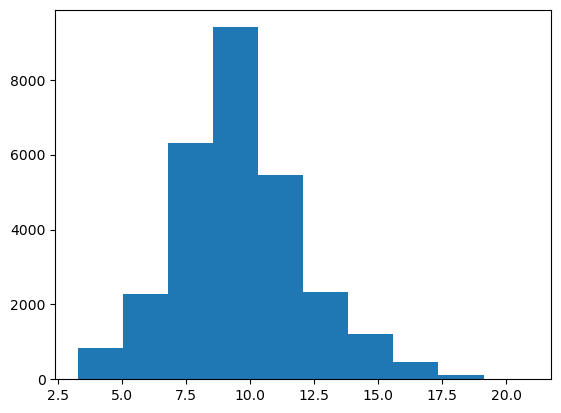

In [124]:
plt.hist(y_pred)

In [130]:
print(evaluator(y_test,y_pred))
print(mean_squared_log_error(y_test,y_pred,squared=False))
feature_importance = cbr.get_feature_importance()
feature_names = np.arange(len(feature_importance))
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

1.153352959700561
0.15199687260550065
    Feature  Importance
14       14   23.758882
2         2   18.087708
12       12   10.742932
4         4    8.943564
18       18    6.534552
16       16    4.838391
5         5    3.289596
13       13    2.975041
10       10    2.713249
15       15    2.343512
3         3    2.134433
0         0    2.069999
1         1    1.954358
11       11    1.844148
6         6    1.648493
19       19    1.296141
9         9    1.166484
17       17    1.063189
8         8    0.974794
20       20    0.908518
7         7    0.712016


In [115]:
good_features = importance_df['Feature'][:20]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


### Feature Engineering

In [71]:
def feature_pipeline(data, drop_id=True, encoding='one-hot', pca_needed=False, std_norm=None, test=[False, None], outlier=False):
    data['comb_vol'] = data['Length'] * data['Diameter'] * data['Height']
    
    data['is_infant'] = data.Sex.apply(lambda x: 1 if x=='I' else 0)
    encoding=None
    data.drop(columns=['Sex'], inplace=True)
    
    data['Whole weight'] = data['Whole weight'].apply(lambda x : np.log1p(x))
    data['Whole weight.1'] = data['Whole weight.1'].apply(lambda x : np.log1p(x))
    data['Whole weight.2'] = data['Whole weight.2'].apply(lambda x : np.log1p(x))
    data['Shell weight'] = data['Shell weight'].apply(lambda x : np.log1p(x)) 

    data['Meat_Yield'] = data['Whole weight.1'] / (data['Whole weight'] + data['Shell weight'])
    data['Shell_Ratio'] = data['Shell weight'] / data['Whole weight']
    data['Weight_to_Shucked_Weight'] = data['Whole weight'] / data['Whole weight.1']
    data['Viscera_Ratio'] = data['Whole weight.2'] / data['Whole weight']


    # data['overall_weight'] = data['Whole weight.1'] + data['Whole weight.2']
    
    
    
    fit_data = data
    if(test[0]==True):
        fit_data = test[1].copy()

    # binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    # binner.fit(np.array(fit_data['Shell weight']).reshape(-1, 1))
    # data['Shell Weight Binned'] = binner.transform(np.array(data['Shell weight']).reshape(-1, 1))
    
    if(drop_id==True):
        data = data.drop(columns=['id'])
    feature_names = data.columns
    if(encoding=='one-hot'):
        data = pd.concat([data,pd.get_dummies(data.Sex)], axis=1).drop(columns=['Sex'])
    elif(encoding=='label'):
        le = LabelEncoder()
        le.fit(np.array(fit_data['Sex']))
        data['Sex'] = le.transform(data['Sex'])
    elif(encoding=='target'):
        te = TargetEncoder(target_type='continuous')
        te.fit(np.array(fit_data['Sex']).reshape(-1, 1),train['Rings'])
        data['Sex'] = te.transform(np.array(data['Sex']).reshape(-1, 1))
    
    if(std_norm=='std'):
        std = StandardScaler()
        std.fit(fit_data)
        data = pd.DataFrame(columns=fit_data.columns, data = std.transform(data))
    elif(std_norm=='norm'):
        scalar = MinMaxScaler()
        scalar.fit(fit_data)
        data = pd.DataFrame(columns=fit_data.columns, data = scalar.transform(data))
        

    print(data.columns)
    if(pca_needed==True):
        pca_columns = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight','comb_vol']
        n_components = len(pca_columns)
        pca = PCA(n_components=n_components)
        pca.fit(fit_data[pca_columns])
        print(np.cumsum(np.array(pca.explained_variance_ratio_ )))
        pca_result= pca.transform(data[pca_columns])
        # n_components=3
        data = pd.concat([data.drop(columns=pca_columns),pd.DataFrame(pca_result.T[:n_components].T, columns=pca_columns[:n_components])],axis=1)
    
    return data, feature_names

In [72]:
# og_trans, fn = feature_pipeline(og.rename(columns={0:'Sex',1:'Length',2:'Diameter',3:'Height',4:'Whole weight',5:'Whole weight.1',
#                    6:'Whole weight.2',7:'Shell weight',8:'Rings'
#                    }
#         ).reset_index().rename(columns={'index':'id'}),
#         drop_id=True, 
#         encoding='one-hot', 
#         pca_needed=False, 
#         std_norm=None,
# )

In [90]:
X, feature_names = feature_pipeline(train.drop(columns=['Rings']), 
                     drop_id=True, 
                     encoding='label', 
                     pca_needed=False, 
                     std_norm=None)
y = train['Rings']

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'comb_vol', 'is_infant', 'Meat_Yield',
       'Shell_Ratio', 'Weight_to_Shucked_Weight', 'Viscera_Ratio'],
      dtype='object')


In [74]:
# X = pd.concat([X, og_trans.drop(columns=['Rings'])], axis=0)
# y = pd.concat([y, og_trans['Rings']], axis=0)

<Axes: >

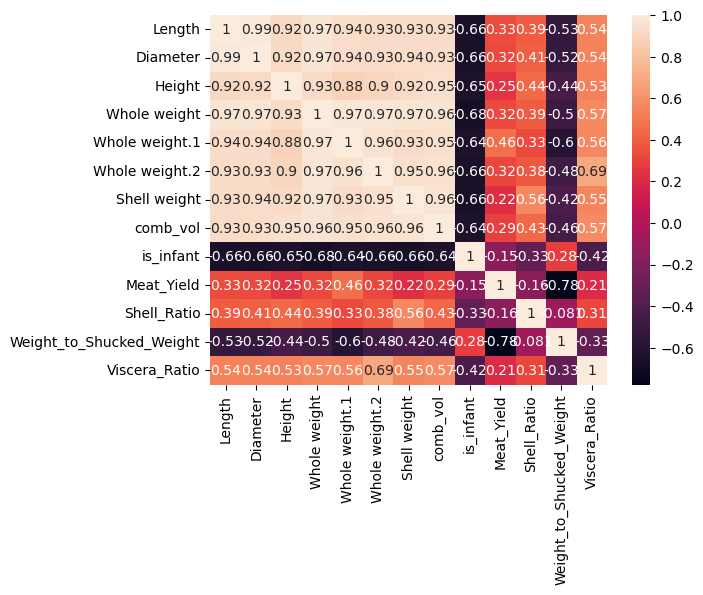

In [75]:
sns.heatmap(X.corr(), annot=True)

In [76]:
def evaluator(y_test, y_pred):
    return np.sqrt(mean_squared_log_error(y_test,abs(y_pred)))

rmle_scorer = make_scorer(evaluator, greater_is_better=False)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=0.3)

y_train = y_train.apply(lambda x: np.log1p(x))

outlier_index = []

for col in X_train.drop(columns=['is_infant']).columns:
    q1 = np.percentile(X_train[col], 25)
    q3 = np.percentile(X_train[col], 75)
    iqr_threshold = (q3-q1)*2.5
    outlier_index += list(X[(X[col] > q3+iqr_threshold) | (X[col] < q1-iqr_threshold)].index)

outlier_index = set(outlier_index)
print(outlier_index)
print(len(outlier_index))


X_train['outlier'] = X_train.index.isin(outlier_index).astype(int)
X_test['outlier'] = X_test.index.isin(outlier_index).astype(int)
feature_names = list(feature_names)
feature_names.append('outlier')

{16384, 49153, 2, 73728, 49156, 32774, 8, 81929, 32782, 8213, 90138, 81947, 28, 29, 30, 49178, 73755, 49185, 65569, 41003, 90158, 57393, 16434, 49205, 81977, 8253, 49214, 41024, 57418, 24651, 83, 87, 93, 41055, 82023, 49255, 107, 82028, 111, 90231, 24703, 57472, 49282, 24710, 65672, 24717, 57517, 57525, 16568, 90300, 24771, 57543, 41161, 82123, 65742, 16600, 8411, 57565, 49374, 8416, 90345, 82156, 90358, 24823, 57605, 41224, 49420, 65806, 41231, 41234, 82195, 16661, 90390, 82201, 74012, 57629, 33053, 41247, 33057, 41257, 82218, 74027, 65841, 57650, 8501, 90422, 16703, 90450, 82261, 8536, 90461, 49503, 74080, 41324, 49522, 375, 74107, 24956, 49531, 49534, 33156, 16773, 74122, 405, 57751, 24983, 57753, 82329, 65945, 57757, 65962, 16812, 25005, 41393, 41404, 82374, 74184, 16841, 25035, 49643, 497, 25086, 41472, 33281, 25095, 25096, 25099, 41489, 74263, 539, 41505, 57905, 578, 74315, 33362, 8789, 57942, 57946, 25183, 25189, 41574, 25191, 74344, 49771, 49780, 82555, 25213, 25215, 33414, 170

### Modeling

#### Baseline Model (Linear Regression)

In [78]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_inv = lr.predict(X_test)
y_pred = np.expm1(y_pred_inv) 
# y_pred = y_pred_inv
print("RMSLE Loss = ", np.sqrt(mean_squared_log_error(y_test,abs(y_pred))))
print("Cross Val Score (mean) = ",
    np.mean(cross_val_score(lr, X_train,y_train, scoring = make_scorer(evaluator), cv= 5, n_jobs=-1 )))
print("Cross Val Score (std)= ",
    np.std(cross_val_score(lr, X_train,y_train, scoring = make_scorer(evaluator), cv= 5, n_jobs=-1 )))
print(lr.intercept_)
print(lr.coef_)
print(feature_names)

RMSLE Loss =  0.1569733762871073
Cross Val Score (mean) =  0.047357621828406936
Cross Val Score (std)=  0.0005293836788821235
1.2092241862820714
[ -0.03144734   0.85403118   3.62042562   0.86998531  -1.77131023
  -0.32107539   2.30802838 -10.01366106  -0.04355092   0.31040545
   0.11883779   0.05793486  -0.04499736  -0.05952592]
['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'comb_vol', 'is_infant', 'Meat_Yield', 'Shell_Ratio', 'Weight_to_Shucked_Weight', 'Viscera_Ratio', 'outlier']


### Advanced Models

In [13]:
data_store = {
    'models':[ 'DecisionTree','RandomForest', 'GradientBoosting', 'XGBRegressor','lgb','CatBoost','MLP'],
    'RMSLE':[]
}

def custom_metric(y_true, y_pred):
    return 'custom_metric', np.sqrt(mean_squared_log_error(y_test,abs(y_pred))), False 

params = {
    'objective': 'regression', 
    'metric': 'custom',            
}
num_round = 100
train_data = lgb.Dataset(X_train, label=y_train)
train_models = [
                DecisionTreeRegressor(random_state=2),
                RandomForestRegressor(random_state=3),
                GradientBoostingRegressor(random_state=4),
                XGBRegressor(random_state=5),
                lgb.train(params, train_data, num_round, feval=custom_metric),
                CatBoostRegressor(random_state=7),
                MLPRegressor(hidden_layer_sizes=(16, 8), activation='relu', solver='adam', max_iter=200, random_state=0)
]
for i in range(len(train_models)):
  rm = train_models[i]
  if(i == 4):
    y_pred_inv = rm.predict(X_test, num_iteration=rm.best_iteration)
  else:
    rm.fit(X_train,y_train)
    y_pred_inv = rm.predict(X_test)
  y_pred = np.expm1(y_pred_inv) 
  data_store['RMSLE'].append(evaluator(y_test,y_pred))

results_df = pd.DataFrame(data_store)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 63430, number of used features: 14
[LightGBM] [Info] Start training from score 2.329614
Learning rate set to 0.078875
0:	learn: 0.2718873	total: 157ms	remaining: 2m 36s
1:	learn: 0.2592515	total: 167ms	remaining: 1m 23s
2:	learn: 0.2478087	total: 189ms	remaining: 1m 2s
3:	learn: 0.2373908	total: 204ms	remaining: 50.7s
4:	learn: 0.2280040	total: 220ms	remaining: 43.7s
5:	learn: 0.2196133	total: 233ms	remaining: 38.6s
6:	learn: 0.2123264	total: 252ms	remaining: 35.7s
7:	learn: 0.2056148	total: 268ms	remaining: 33.3s
8:	learn: 0.1997736	total: 281ms	remaining: 30.9s
9:	learn: 0.1943535	total: 289ms	remaining: 28.7s
10:	learn: 0.1896563	total: 298ms	remaining: 2

In [15]:
results_df

,models,RMSLE
0,DecisionTree,0.215990
1,RandomForest,0.152987
2,GradientBoosting,0.151299
3,XGBRegressor,0.151465
4,lgb,0.149491
5,CatBoost,0.149113
6,MLP,0.153845


### Chosen Model

In [79]:
cbr = CatBoostRegressor(
    random_strength= 2, 
    learning_rate= 0.1, 
    l2_leaf_reg= 10, 
    iterations= 1000, 
    depth= 6,
    random_state=7,
    silent=True,
    max_bin = 2048
)
cbr.fit(X_train,y_train)
y_pred_inv = cbr.predict(X_test)
y_pred = np.expm1(y_pred_inv) 
print(evaluator(y_test,y_pred))
print(mean_squared_log_error(y_test,y_pred,squared=False))

0.14930681431789747
0.14930681431789747


In [ ]:
feature_importance = cbr.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

### Equal Weightage

In [ ]:
params = {
    'objective': 'regression', 
    'metric': 'custom',  
    'num_leaves': 30, 
    'n_estimators': 300, 
    'max_depth': 10, 
    'learning_rate': 0.05          
}
train_data = lgb.Dataset(X_train, label=y_train)
weight_models = [
    CatBoostRegressor(
    random_strength= 2, 
    learning_rate= 0.1, 
    l2_leaf_reg= 10, 
    iterations= 1000, 
    depth= 6,
    random_state=7,
    silent=True,
    max_bin = 2048
    ), 
    XGBRegressor(subsample= 0.9, reg_lambda=1.5, reg_alpha= 1, n_estimators= 1000, min_child_weight= 5, 
                 max_depth=6, learning_rate= 0.01, gamma=0, colsample_bytree= 0.7, random_state=5),
    lgb.train(params, train_data, num_round, feval=custom_metric)
]
final_pred = []
for i in range(len(weight_models)):
  rm = weight_models[i]
  print(rm)
  if(i == 2):
    y_pred_inv = rm.predict(X_test, num_iteration=rm.best_iteration)
  else:
    rm.fit(X_train,y_train)
    y_pred_inv = rm.predict(X_test)
  y_pred = np.expm1(y_pred_inv) 
  # y_pred = y_pred_inv
  final_pred.append(y_pred)

final_pred = lr.intercept_ + np.array(final_pred)
# final_pred = np.mean(final_pred, axis=0)

In [ ]:
print(evaluator(y_test,final_pred))
print(mean_squared_log_error(y_test,final_pred,squared=False))

### Weighted Average decision

In [29]:
from sklearn.ensemble import VotingRegressor
scores = []
params = {
    'objective': 'regression', 
    'metric': 'custom',  
    'num_leaves': 30, 
    'n_estimators': 300, 
    'max_depth': 10, 
    'learning_rate': 0.05          
}
train_data = lgb.Dataset(X_train, label=y_train)
weight_models = [
    CatBoostRegressor(
    random_strength= 2, 
    learning_rate= 0.1, 
    l2_leaf_reg= 10, 
    iterations= 1000, 
    depth= 6,
    random_state=7,
    silent=True,
    max_bin = 2048
    ), 
    XGBRegressor(subsample= 0.9, reg_lambda=1.5, reg_alpha= 1, n_estimators= 1000, min_child_weight= 5, 
                 max_depth=6, learning_rate= 0.01, gamma=0, colsample_bytree= 0.7, random_state=5),
    lgb.train(params, train_data, num_round, feval=custom_metric)
]
final_pred = []
for i in range(len(weight_models)):
  rm = weight_models[i]
  print(rm)
  if(i == 2):
    y_pred_inv = rm.predict(X_test, num_iteration=rm.best_iteration)
  else:
    rm.fit(X_train,y_train)
    y_pred_inv = rm.predict(X_test)
  y_pred = np.expm1(y_pred_inv) 
  scores.append(evaluator(y_test,y_pred))


c:\Users\surya\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 63430, number of used features: 14
[LightGBM] [Info] Start training from score 2.329614
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=

In [44]:
scores = [score.round(5) for score in scores]

In [45]:
np.argsort(scores)

array([1, 2, 0], dtype=int64)

In [46]:
ranking = 1 + (np.argsort(scores))
print(ranking)

[2 3 1]


In [80]:
models = list([('cat', CatBoostRegressor(
    random_strength= 2, 
    learning_rate= 0.1, 
    l2_leaf_reg= 10, 
    iterations= 1000, 
    depth= 6,
    random_state=7,
    silent=True,
    max_bin = 2048
    )),('xgb', XGBRegressor(subsample= 0.9, reg_lambda=1.5, reg_alpha= 1, n_estimators= 1000, min_child_weight= 5, 
                 max_depth=6, learning_rate= 0.01, gamma=0, colsample_bytree= 0.7, random_state=5)),
                 ('lgb', lgb.LGBMRegressor(**params))]
)

In [81]:
ensemble = VotingRegressor(estimators=models, weights=ranking)
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
y_pred = np.expm1(yhat) 
# evaluate predictions
score = evaluator(y_test, y_pred)
print('Weighted Avg MAE: %.5f' % (score))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 63430, number of used features: 14
[LightGBM] [Info] Start training from score 2.329614
Weighted Avg MAE: 0.14892


In [82]:
ensemble = VotingRegressor(estimators=models, weights=scores)
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
y_pred = np.expm1(yhat) 
# evaluate predictions
score = evaluator(y_test, y_pred)
print('Weighted Avg MAE: %.5f' % (score))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 63430, number of used features: 14
[LightGBM] [Info] Start training from score 2.329614
Weighted Avg MAE: 0.14892


### Hyper-parameter tuning

In [16]:
lgb_model = lgb.LGBMRegressor()

# Define hyperparameters grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 10, 15]
}

# Instantiate GridSearchCV
rand_search = RandomizedSearchCV(estimator=lgb_model, 
                                 param_distributions=param_grid, 
                                 cv=3, 
                                 n_iter=20,
                                 n_jobs=-1,
                                 scoring=rmle_scorer, 
                                 verbose=0,
                                 random_state=43)

# Perform grid search to find the best hyperparameters
rand_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best Hyperparameters:", rand_search.best_params_)
print("Best Mean Squared Error:", rand_search.best_score_)
y_pred_inv = rand_search.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_inv) 
rmle = evaluator(y_test,y_pred)
print("Evaluation:", rmle)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 63430, number of used features: 14
[LightGBM] [Info] Start training from score 2.329614
Best Hyperparameters: {'num_leaves': 30, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05}
Best Mean Squared Error: -0.04510726047205104
Evaluation: 0.1492023103671882


In [25]:
# CATBOOST

param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'iterations': [100, 200, 500, 1000], 
    'depth': [4, 6, 8, 10], 
    'l2_leaf_reg': [1, 3, 5, 7, 10], 
    'random_strength': [0.1, 1, 2, 5]
}

model = CatBoostRegressor(
    random_state=7,
    silent=True, 
)


random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=20,  
    scoring=rmle_scorer, 
    n_jobs=-1,  
    cv=5,  
    random_state=42, 
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = random_search.best_estimator_

y_pred_inv = best_model.predict(X_test)
y_pred = np.expm1(y_pred_inv) 
rmle = evaluator(y_test,y_pred)
print("Evaluation:", rmle)

Best Hyperparameters: {'random_strength': 2, 'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 1000, 'depth': 6}
Evaluation: 0.14913560873767412


In [17]:
#XGBoost

model = XGBRegressor(
    objective='reg:squarederror', 
    verbosity=0  
)

# Define the hyperparameters to tune
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 500, 1000],  
    'max_depth': [4, 6, 8, 10],  # Depth of trees
    'min_child_weight': [1, 3, 5],  
    'gamma': [0, 0.1, 0.2, 0.5],  
    'subsample': [0.7, 0.8, 0.9], 
    'colsample_bytree': [0.7, 0.8, 0.9], 
    'reg_alpha': [0, 0.1, 0.5, 1], 
    'reg_lambda': [1, 1.5, 2], 
}

# Configure RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter combinations to try
    scoring=rmle_scorer,  # Scoring metric for regression tasks
    n_jobs=-1,  # Use all available CPU cores
    cv=5,  # 5-fold cross-validation
    random_state=42,  # For reproducibility
)

# Fit the RandomizedSearchCV with the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions with the best model on the test set
y_pred_inv = best_model.predict(X_test)
y_pred = np.expm1(y_pred_inv) 

# Calculate and display the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
rmle = evaluator(y_test,y_pred)
print("Evaluation:", rmle)

Best Hyperparameters: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}
Evaluation: 0.1491683925956187


### Test Pipelining

In [94]:
final_test, feature_names = feature_pipeline(test, 
                     drop_id=True, 
                     encoding='one-hot', 
                     pca_needed=False, 
                     std_norm=None,
                     test=[True, train.drop(columns=['Rings'])])

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'comb_vol', 'is_infant', 'Meat_Yield',
       'Shell_Ratio', 'Weight_to_Shucked_Weight', 'Viscera_Ratio'],
      dtype='object')


### Submission

In [95]:
sample_submission.head()

,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,10
4,90619,10


In [96]:
outlier_index = []
outlier_index_t = []

for col in X.drop(columns=['is_infant']).columns:
    q1 = np.percentile(X[col], 25)
    q3 = np.percentile(X[col], 75)
    iqr_threshold = (q3-q1)*2.5
    outlier_index += list(X[(X[col] > q3+iqr_threshold) | (X[col] < q1-iqr_threshold)].index)
    outlier_index_t += list(final_test[(final_test[col] > q3+iqr_threshold) | (final_test[col] < q1-iqr_threshold)].index)


X['outlier'] = X.index.isin(outlier_index).astype(int)
final_test['outlier'] = final_test.index.isin(outlier_index_t).astype(int)

In [92]:
y = y.apply(lambda x : np.log1p(x))
params = {
    'objective': 'regression', 
    'metric': 'custom',  
    'num_leaves': 30, 
    'n_estimators': 300, 
    'max_depth': 10, 
    'learning_rate': 0.05          
}
weight_models = [
    CatBoostRegressor(
    random_strength= 2, 
    learning_rate= 0.1, 
    l2_leaf_reg= 10, 
    iterations= 1000, 
    depth= 6,
    random_state=7,
    silent=True,
    max_bin = 2048
    ), 
    XGBRegressor(subsample= 0.9, reg_lambda=1.5, reg_alpha= 1, n_estimators= 1000, min_child_weight= 5, 
                 max_depth=6, learning_rate= 0.01, gamma=0, colsample_bytree= 0.7, random_state=5),
    lgb.train(params, lgb.Dataset(X, label=y), num_round, feval=custom_metric)
]

predictions = []
for i in range(len(weight_models)):
  rm = weight_models[i]
  print(rm)
  if(i == 2):
    predictions_inv = rm.predict(final_test, num_iteration=rm.best_iteration)
  else:
    rm.fit(X,y)
    predictions_inv = rm.predict(final_test)
  y_pred = np.expm1(predictions_inv) 
  # y_pred = predictions_inv
  predictions.append(y_pred)

predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)

c:\Users\surya\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 14
[LightGBM] [Info] Start training from score 9.696794
[ 9.81565157  9.74352313 10.1228754  ... 13.53915065 13.86566555
  8.38860266]
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_ste

In [58]:
ensemble.fit(X, y)
predictions_inv = ensemble.predict(final_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 14
[LightGBM] [Info] Start training from score 9.696794


In [97]:
rm = CatBoostRegressor(random_strength= 2, 
                       learning_rate= 0.1, 
                       l2_leaf_reg= 10, 
                       iterations= 1000, 
                       depth= 6,
                       random_state=7,
                       silent=True, 
                       )
y = y.apply(lambda x : np.log1p(x))
rm.fit(X,y)
predictions_inv = rm.predict(final_test)
predictions = np.expm1(predictions_inv) 
# predictions = np.round(abs(rm.predict(final_test, num_iteration=rm.best_iteration)))

In [104]:
submission_df = pd.DataFrame({'id':test.id, 'Rings':predictions})

<Axes: >

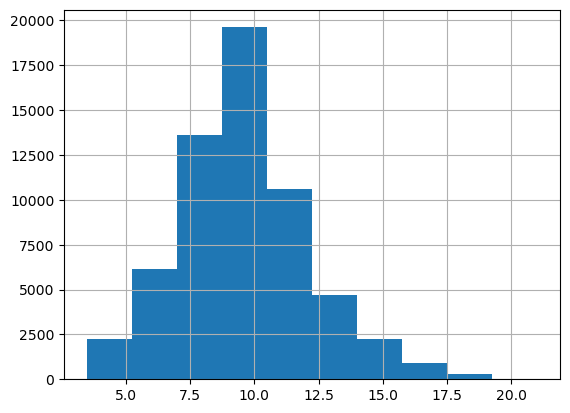

In [105]:
submission_df.Rings.hist()

In [106]:
submission_df.to_csv("E:/Kaggle/Abalone Dataset/final_submission.csv", index=False)